# <center> <font style="color:rgb(100,109,254)"> Image Classification with HOG + SVM </font> </center>

We have seen the working of HOG and SVM, now we will make an Image Classifier that will classify our Static Hand gestures to alphabets. So yes we will be doing ASL (American Sign Language Classification). 

Note: We will use HOG in OpenCV and SVM from sckit-learn Library, Now sckit-learn is one of the most popular and effective library for machine learning, its popularity is mostly due to its low learning curve and flexibility.

OpenCV also contains an implementation of Support vector machines but its buggy, which is why we'll be using scikit-learn's SVM.

In [1]:
# Importing the Required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn import svm
from tqdm import tqdm_notebook as tqdm

## <font style="color:rgb(134,19,348)"> Load the Training Classes </font>

In [2]:
# Path for our training data.
training_path = 'Media/M4/ASL_DATASET_1/ASL_TRAIN' 

# The names of our image classes are the names of sub folders.
train_classes = [directory for directory in os.listdir(training_path) if os.path.isdir(os.path.join(training_path,directory))]

**Same Procedure for our test data, We will use test data to check performance of our model after its trained**

In [3]:
test_path='Media/M4/ASL_DATASET_1/ASL_TEST' 
test_classes = [directory for directory in os.listdir(test_path) if os.path.isdir(os.path.join(test_path,directory))]

In [4]:
# Check out the labels in the training set.
print(train_classes)

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## <font style="color:rgb(134,19,348)">Display a single Image from Each Class and the total number of classes  </font>

Number of Samples in Class A: 500
Number of Samples in Class B: 501
Number of Samples in Class C: 501
Number of Samples in Class D: 501
Number of Samples in Class del: 501
Number of Samples in Class E: 501
Number of Samples in Class F: 501
Number of Samples in Class G: 501
Number of Samples in Class H: 501
Number of Samples in Class I: 501
Number of Samples in Class J: 501
Number of Samples in Class K: 501
Number of Samples in Class L: 501
Number of Samples in Class M: 501
Number of Samples in Class N: 501
Number of Samples in Class nothing: 501
Number of Samples in Class O: 501
Number of Samples in Class P: 501
Number of Samples in Class Q: 501
Number of Samples in Class R: 501
Number of Samples in Class S: 501
Number of Samples in Class space: 501
Number of Samples in Class T: 501
Number of Samples in Class U: 501
Number of Samples in Class V: 501
Number of Samples in Class W: 501
Number of Samples in Class X: 501
Number of Samples in Class Y: 501
Number of Samples in Class Z: 501


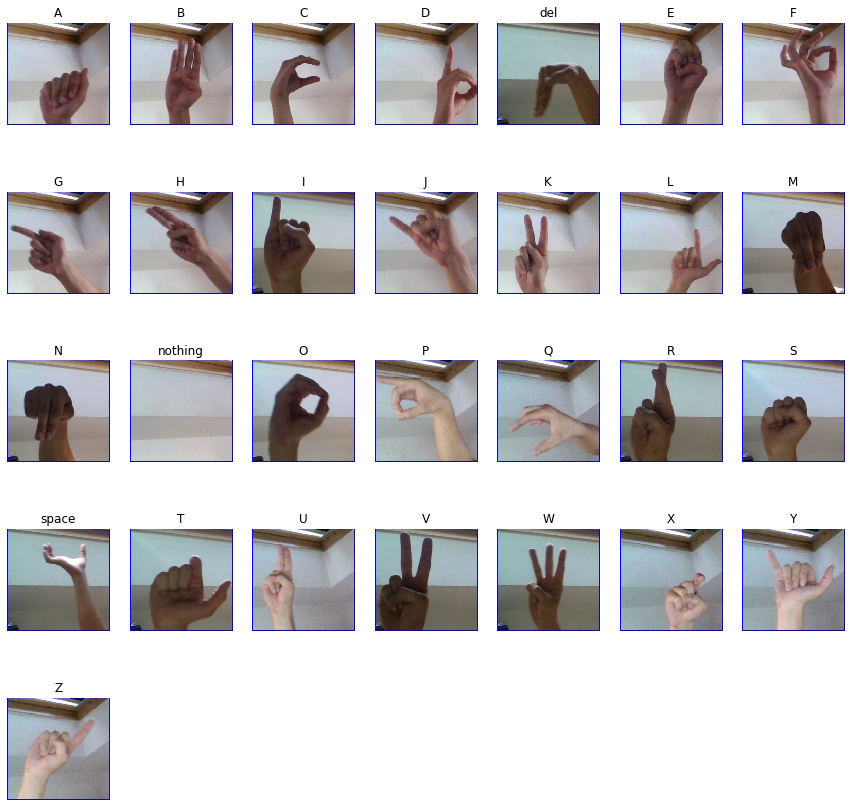

In [5]:
# Determine size, cols and rows for display
plt.figure(figsize=[15,15])
cols = 7
rows = int(np.ceil(len(train_classes)/cols))

# Loop for each class
for i in range(len(train_classes)):
    
        # Take the 2nd image from each class       
        name = os.listdir( os.path.join(training_path,train_classes[i]))[1]

        print('Number of Samples in Class {}: {}'.format(train_classes[i], 
                                                         len(os.listdir( os.path.join(training_path,train_classes[i] )))))
        # Read and display image
        image = cv2.imread(os.path.join(training_path,train_classes[i],name))
        plt.subplot(rows,cols,i+1);plt.imshow(image[:,:,::-1]);plt.title(train_classes[i]);plt.axis('off');

## <font style="color:rgb(134,19,348)"> Initialize Hog Descriptor  </font>


You can use `cv2.HOGDescriptor()`to initialize the hog descriptor, you can use it with its default params or change it when you want different parameter values.

[```
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, L2HysThreshold, gammaCorrection, nlevels, SignedGradients)```](https://docs.opencv.org/4.2.0/d5/d33/structcv_1_1HOGDescriptor.html#a5c8e8ce0578512fe80493ed3ed88ca83)


- **`winSize`**: This parameter is set to the size of the window over which the descriptor is calculated, since we want to calculate the whole image which is 64x128, so we will set it to that value.

- **`blockSize`** : This is the block size over which normalization is performed to counter illumination changes, normally we set this to 2 x cell size. 

- **`blockStride`** : This is the stride that the block size kernel will take when normalizing, a good value for this can be 50%  of the block Size.

- **`cellSize`** : These are those 8x8 cells. A small cell size will increase the length of feature vector and a larger one may not capture enough information.

- **`nbins`** : This is the number of bins in the histogram of gradients. The authors of the HOG paper used a value of 9 to capture gradients between 0 and 180 degrees, these are with 20 degree increments.

- **`derivAperture`** :  This is the size of the Sobel kernel used for derivative calculation, OpenCV's Hog descriptor does not utilize this parameter.

- **`winSigma`** : This is a Gaussian smoothing window operation, this is done prior to accumulating orientation votes, leaving this to -1 allows it to automatically compute a value for this using the formula:  *winSigma = ( blockSize.width + block Size.height ) / 8*

- **`histogramNormType`** : In the HOG paper, the authors use four different kinds of normalization. OpenCV Only implements only L2Hys. So this parameter does not have any effect as its not used in the function. L2Hys is simply L2 normalization followed by a threshold (L2HysThreshold) where all the values above a particular threshold are made equal to that threshold value.

- **`L2HysThreshold`** : This is the Threshold used in L2Hys normalization. E.g. 

- **`gammaCorrection`** : Boolean Variable deciding whether or not Gamma correction should be used as a pre-processing step.

- **`nlevels`** : This is the number of pyramid levels used during Object detection, this param does not have an effect when HOG descriptor is used for classification.

- **`signedGradient`** : This is a boolean variable which decides whether to  use Signed Gradients or not. Signed Gradients (having both positive and negative directions) can have any orientations between 0 and 360 degrees. Unsigned gradients takes the value between 0 and 180 degrees. In the original HOG paper, unsigned gradients were used for pedestrian detection.



In [6]:
# Initialize hog parameters, I'm initializing with all the default values.
winSize = (64, 128) 
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1 # has no effect 
winSigma = -1 # going to be equal to 4
histogramNormType = 1 # has no effect 
L2HysThreshold = 0.2
gammaCorrection = False
nlevels = 64 
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, 
                        L2HysThreshold, gammaCorrection, nlevels, signedGradient)

### <font style="color:rgb(134,19,348)">Compute Hog Descriptors  </font>

You can compute hog descriptor of any image now by using **`hog.compute(image)`**.

In [7]:
# Read Image
img = cv2.imread(os.path.join(training_path, 'A/A9.jpg'))

# Resize to 64x128
img = cv2.resize(img, (64, 128))

# Compute the hog descriptor
descriptor = hog.compute(img)

# Display Descriptor Size
print('The shape of the descriptor is {}'.format(descriptor.shape))

The shape of the descriptor is (3780, 1)


## <font style="color:rgb(134,19,348)"> Compute and Store Hog Feature Vectors of images </font>

Now we will loop through each image and store its feature vector and label. Label of any image is the name of the class it belongs. 

**Start Feature & Label Extraction**

In [8]:
def getfeaturevectors(path, classes, samples=50, start_index = 0):
    # This list will hold the final feature vectors.
    Hog_feature_vectors = []

    # This list will hold the labels for each image.
    labels = []

    # This loop loops for each class (in total we have 29 classes for this dataset), we're also using tqdm for a progress bar.
    for i in tqdm(range(len(classes))):

            # This loop loops for each sample in each class (each class have approximately)
            for j in os.listdir(os.path.join(path, classes[i]))[start_index:samples]:

                # Read the image
                image = cv2.imread(os.path.join(path, classes[i], j))

                # Resize the image, if the image is corrupted then leave it 
                try:
                    image = cv2.resize(image, (64, 128))
                    
                except:
                    #print('Error Readimg image {}'.format(os.path.join(path,classes[i], j)))
                    continue

                # Compute the descriptor            
                descriptor = hog.compute(image)

                # Store the feature vector and the label
                Hog_feature_vectors.append(descriptor.reshape(-1))

                # Also store the label for each class
                labels.append(classes[i])

    print('Total Descriptors: {} and Total Labels: {}'.format(len(Hog_feature_vectors), len(labels) ))
    
    # Return the feature vectors with their labels.
    return Hog_feature_vectors, labels

**Lets use our function to get features and labels for the training data**

In [14]:
Hog_feature_vectors, labels = getfeaturevectors(training_path, train_classes, samples=300)


Total Descriptors: 8676 and Total Labels: 8676


## <font style="color:rgb(134,19,348)"> Initialize the SVM Classifier </font>


```Python
model = svm.SVC()
```
- **`C:`** a float value, optional (default=1.0)
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- **`kernel:`** a string, optional (default=`rbf`)
Specifies the kernel type to be used in the algorithm. It must be one of `linear`, `poly`, `rbf`,  or `sigmoid`. If none is given, `rbf` will be used. 

- **`degree:`** an int, optional (default=3)
Degree of the polynomial kernel function (`poly`). Ignored by all other kernels.

- **`gamma:`** string, optional (default=`scale`)
Possible values are `scale` and `auto` Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. if gamma=`scale`(default) is passed then it uses `1 / (n_features * X.var())` as value of gamma, and if `auto`, it uses `1 / n_features`

You can look at other parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [15]:
# Initializing SVM Model with rbf kernel 
model = svm.SVC(kernel='rbf', C = 30.0, gamma='scale')

##  <font style="color:rgb(134,19,348)">Start Training the Model  </font>

You can start training with svm by calling the `model.fit()` method.

In [16]:
model.fit(Hog_feature_vectors, labels)
print("Training Completed")

Training Completed


## <font style="color:rgb(134,19,348)">Setting up the Test data for Evaluation  </font>


In [19]:
Hog_feature_test_vectors, test_labels = getfeaturevectors(test_path, test_classes, samples = 50)


Total Descriptors: 1426 and Total Labels: 1426


## <font style="color:rgb(134,19,348)">Evaluating performance on Test Data  </font>

Now you can evaluate this data by using the function **`model.score()`**

In [20]:
score = model.score(Hog_feature_test_vectors, test_labels)
print('Accuracy of Model is {:.2f}%'.format(score*100))

Accuracy of Model is 81.21%


##  <font style="color:rgb(134,19,348)">Save and Load Models for later use  </font>

First import the pickle library and then use `pickle.dump()` function. So pickle library allows you to serialize your machine learning model and save the serialized format to a file.

In [21]:
pickle.dump(model, open('Media/M4/svm_asl_default.sav', 'wb'))

**Later on a different notebook you can load back the model by using `pickle.load()`, here `wb` and `rb` are write binary and read binary operations**

In [22]:
# load the model from disk
loaded_model = pickle.load(open('Media/M4/svm_asl_default.sav', 'rb'))

## <font style="color:rgb(134,19,348)">Predict on a Single Image  </font>

Now once you're satisfied with the performance of your model then its ready to predict on new images using `model.predict()`.

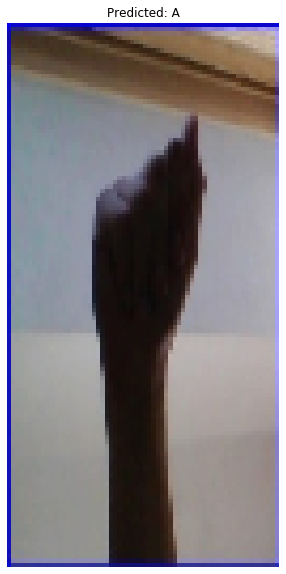

In [23]:
# Read Image
img = cv2.imread(os.path.join(training_path, 'A/A9.jpg'))

# Resize to 64x128
img = cv2.resize(img, (64, 128))

# Compute the hog descriptor
descriptor = hog.compute(img)

# predict on the image and get the label
label = loaded_model.predict(descriptor.reshape(1,-1))[0]

plt.figure(figsize=[10,10])
plt.imshow(img[:,:,::-1]);plt.title('Predicted: {}'.format(label));plt.axis('off');

###  <font style="color:rgb(34,169,134)"> Assignment: Make a Custom CLASSIFIER </font>
Your task is to build a classifier with your own custom set and then get a decent test accuracy on it.